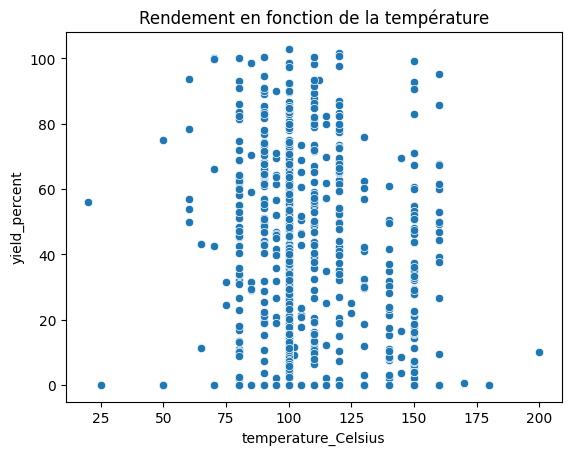

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("datas/buchwald_full_clean.csv")

sns.scatterplot(x="temperature_Celsius", y="yield_percent", data=df)
plt.title("Rendement en fonction de la température")
plt.show()

In [2]:
morgan_gen = GetMorganGenerator(radius=3, fpSize=2048)

def mol_to_fp(smiles):
    if not isinstance(smiles, str) or smiles.strip() == "":
        return np.zeros((2048,))
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((2048,))
    return np.array(morgan_gen.GetFingerprint(mol))

fps_base = np.array([mol_to_fp(s) for s in df['inputs_base_SMILES']])
fps_solvent = np.array([mol_to_fp(s) for s in df['inputs_solvent_SMILES']])
fps_amine= np.array([mol_to_fp(s) for s in df['inputs_amine_SMILES']])
fps_aryl_halide= np.array([mol_to_fp(s) for s in df['inputs_aryl_halide_SMILES']])


X_fp = np.hstack([fps_base, fps_solvent, fps_amine, fps_aryl_halide])


[21:33:51] WARNING: not removing hydrogen atom without neighbors


In [3]:
# Préparation des données d'entrée
X = np.hstack([df[['temperature_Celsius']].values, X_fp])
y = df['yield_percent'].values# Grille meilleurs paramètres

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("Meilleur score R² :", grid.best_score_)
print("Meilleurs paramètres :", grid.best_params_)

NameError: name 'X_train' is not defined

In [4]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Modèle Random Forest
model = RandomForestRegressor(n_estimators=300, random_state=200, max_features='sqrt', min_samples_split=2)
model.fit(X_train, y_train)

# 5. Prédictions et évaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² sur test : {r2_score(y_test, y_pred):.3f}")
print(f"RMSE sur test : {rmse:.3f}")

R² sur test : 0.272
RMSE sur test : 25.894


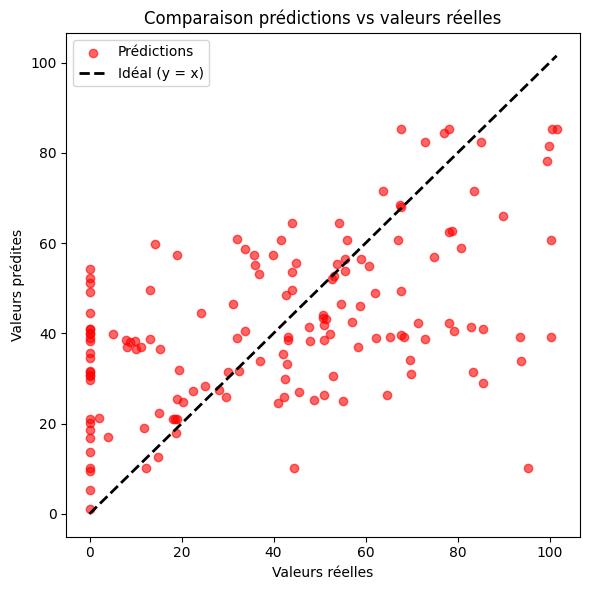

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='red', alpha=0.6, label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Idéal (y = x)')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison prédictions vs valeurs réelles')
plt.legend()
plt.tight_layout()
plt.show()